In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn import linear_model, preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import KFold, learning_curve, cross_val_score, train_test_split
from joblib import dump

In [2]:
# stu_por = pd.read_csv('student-por.csv')
# Loading the dataset
df = pd.read_csv('student-por.csv')
df.sample(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
419,GP,M,19,U,GT3,T,2,1,other,other,...,5,3,4,1,4,4,10,7,11,11
445,MS,M,15,R,GT3,T,1,1,other,other,...,5,4,5,2,4,4,8,7,9,9
155,GP,M,17,U,GT3,T,2,1,other,other,...,5,4,5,1,2,5,22,9,7,6
439,MS,F,15,R,GT3,T,3,3,other,services,...,4,1,3,1,1,4,0,14,16,16
203,GP,M,17,R,GT3,T,1,2,at_home,other,...,3,1,3,1,5,3,6,9,9,10


In [3]:
df['Average Grades'] = df[['G1', 'G2', 'G3']].mean(axis='columns')
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,Average Grades
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,4,0,11,11,7.333333
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,2,9,11,11,10.333333
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,6,12,13,12,12.333333
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,2,1,1,5,0,14,14,14,14.000000
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,0,11,13,13,12.333333


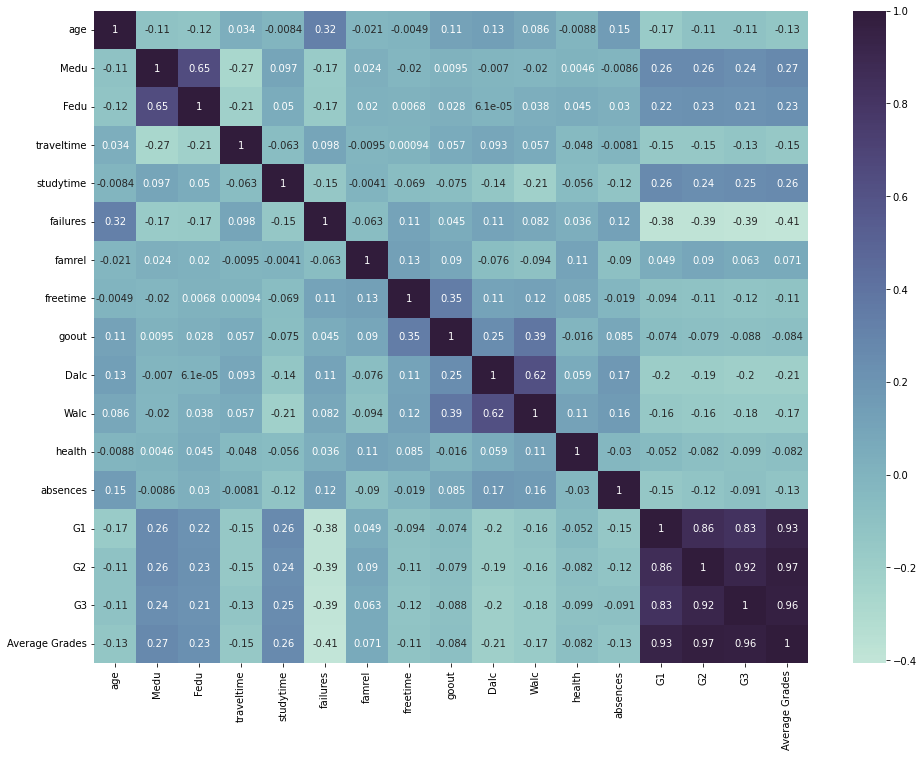

In [4]:
def plot_corr(df, annot=True):
    _, ax = plt.subplots(figsize=(16, 12))
    sns.heatmap(
        df.corr(),
        annot=annot,
        cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True),
        ax=ax
    )
plot_corr(df)

In [5]:
ohe_df = pd.get_dummies(df.select_dtypes('object'))
ohe_df.head()

,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,1,0,1,0,0,1,1,0,1,0,...,1,0,0,1,0,1,1,0,1,0
1,1,0,1,0,0,1,1,0,0,1,...,1,0,1,0,0,1,0,1,1,0
2,1,0,1,0,0,1,0,1,0,1,...,1,0,0,1,0,1,0,1,1,0
3,1,0,1,0,0,1,1,0,0,1,...,0,1,0,1,0,1,0,1,0,1
4,1,0,1,0,0,1,1,0,0,1,...,1,0,0,1,0,1,1,0,1,0


In [6]:
# Removing one column after doing one hot encoding to avoid multi-collinearity issues
ohe_df.drop(['romantic_yes'], axis='columns', inplace=True)

In [7]:
# Removing the categorical columns and adding one hot encoded df

# Removing
categorical_columns = df.select_dtypes('object').columns.tolist()
df.drop(categorical_columns, axis='columns', inplace=True)

# Adding
df = pd.concat([df, ohe_df], axis='columns')
df.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,paid_yes,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no
0,18,4,4,2,2,0,4,3,4,1,...,0,1,0,0,1,0,1,1,0,1
1,17,1,1,1,2,0,5,3,3,1,...,0,1,0,1,0,0,1,0,1,1
2,15,1,1,1,2,0,4,3,2,2,...,0,1,0,0,1,0,1,0,1,1
3,15,4,2,1,3,0,3,2,2,1,...,0,0,1,0,1,0,1,0,1,0
4,16,3,3,1,2,0,4,3,2,1,...,0,1,0,0,1,0,1,1,0,1


In [8]:
# Since is collinear to G1, G2 & G3
df.drop(['Average Grades'], axis='columns', inplace=True)

In [9]:
kf = KFold(n_splits=10, shuffle=True)

In [10]:
# Shuffling the dataset
df = df.sample(frac=1, random_state=5)

In [11]:
features = ['failures', 'Medu', 'studytime', 'absences', 'G1', 'G2', 'higher_no', 'higher_yes']
target = 'G3'

x_train, x_test, y_train, y_test = train_test_split(
    df[features], df[target], test_size=0.3, random_state=0
    
)
print(x_test)

     failures  Medu  studytime  absences  G1  G2  higher_no  higher_yes
608         0     1          2         2   8  10          0           1
81          0     2          3         2  10   9          0           1
475         0     2          3         0  12  13          0           1
41          0     4          1         8  10  11          0           1
381         0     4          3         4  15  14          0           1
..        ...   ...        ...       ...  ..  ..        ...         ...
483         0     2          2         1   9  10          1           0
27          0     4          1         0  11  11          0           1
431         1     3          2         0  10  10          0           1
53          0     4          1         0  13  12          0           1
420         0     2          2        10  14  17          0           1

[195 rows x 8 columns]


In [12]:
# scaler = StandardScaler()

# x_train = scaler.fit_transform(np.asanyarray(x_train))
# y_train = np.asanyarray(y_train)

# x_test = scaler.fit_transform(np.asanyarray(x_test))
# y_test = np.asanyarray(y_test)
# print(x_test)

In [13]:
# Cross Validation
scoring = 'r2'
score = cross_val_score(linear_model.LinearRegression(), x_train, y_train, cv=4, scoring=scoring)
score.mean()

0.8781317742387502

In [14]:
# Plotting learning curve
_sizes = [i for i in range(1, 408, 10)]
train_sizes = np.array([_sizes])  # Relative sizes
scoring = 'neg_mean_squared_error'

lr = linear_model.LinearRegression()
train_sizes_abs, train_scores, cv_scores = learning_curve(
    lr, x_train, y_train, train_sizes=train_sizes, cv=10, scoring=scoring
)

In [15]:
train_scores_mean = []
for row in train_scores:
    _mean = row.mean()
    train_scores_mean.append(_mean)
    
cv_scores_mean = []
for row in cv_scores:
    _mean = row.mean()
    cv_scores_mean.append(_mean)    
    
train_scores_mean = -np.array(train_scores_mean)
cv_scores_mean = -np.array(cv_scores_mean)
    
print(train_scores_mean)
print()
print(cv_scores_mean)

[-0.          0.85613956  0.7643425   0.83625408  0.93876304  0.90017885
  0.84846326  0.89736381  0.92383124  1.26533395  1.23625874  1.20042449
  1.19653196  1.16276982  1.12585006  1.12803344  1.09643962  1.13880433
  1.11641169  1.08223887  1.16914588  1.21385534  1.18727435  1.16475763
  1.21076425  1.17422027  1.15050472  1.1314317   1.112499    1.10836223
  1.08613118  1.0719779   1.05303998  1.0545543   1.05508069  1.03952044
  1.02269886  1.01192197  1.00314227  0.99623394  0.98482049]

[10.13608696  6.15675515  1.81700701  2.13255792  1.42163618  1.36438714
  1.31105831  1.30608981  1.22802515  1.33081133  1.28308077  1.26179323
  1.24542221  1.22377434  1.21832087  1.20960274  1.19524758  1.19715384
  1.19271179  1.18960296  1.1897708   1.18533794  1.18607429  1.18561615
  1.18706069  1.19000089  1.18531209  1.18566767  1.18174233  1.17724346
  1.17736314  1.17340897  1.17369638  1.17229769  1.17436037  1.17480713
  1.17296237  1.17370644  1.17578775  1.17381633  1.17335333]

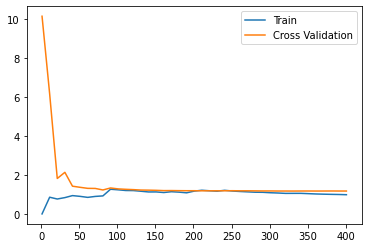

In [16]:
plt.plot(train_sizes_abs, train_scores_mean, label='Train')
plt.plot(train_sizes_abs, cv_scores_mean, label='Cross Validation')

plt.legend()

In [17]:
model = lr.fit(x_train, y_train)

In [18]:
# Optimal parameter
coefficients = model.coef_
intercept = model.intercept_

print("Coefficients: ", coefficients)
print("Intercept: ", model.intercept_)

Coefficients:  [-0.05679304 -0.04937337  0.06596793  0.00676679  0.14845824  0.8622346
 -0.14990694  0.14990694]
Intercept:  0.1333245252799724


In [19]:
print(type(x_test))
print((x_test))
for i in x_test:
    print(i)
y_test_pred = model.predict(x_test)

<class 'pandas.core.frame.DataFrame'>
     failures  Medu  studytime  absences  G1  G2  higher_no  higher_yes
608         0     1          2         2   8  10          0           1
81          0     2          3         2  10   9          0           1
475         0     2          3         0  12  13          0           1
41          0     4          1         8  10  11          0           1
381         0     4          3         4  15  14          0           1
..        ...   ...        ...       ...  ..  ..        ...         ...
483         0     2          2         1   9  10          1           0
27          0     4          1         0  11  11          0           1
431         1     3          2         0  10  10          0           1
53          0     4          1         0  13  12          0           1
420         0     2          2        10  14  17          0           1

[195 rows x 8 columns]
failures
Medu
studytime
absences
G1
G2
higher_no
higher_yes


In [20]:
y_test_pred

array([10.18933949,  9.64061593, 13.37293723, 11.17500331, 14.608867  ,
        9.16004628, 15.08115002, 16.09184286, 12.58442035, 15.43220086,
       10.20150318, 11.22067085, 15.3750777 , 12.32905528,  9.44577312,
       13.55145146, 10.34860849, 17.34974068, 11.42799209, 10.68136476,
       10.57180726, 12.64290446, 13.51833451, 12.58442035, 11.54359936,
        0.95996506, 16.47873348, 14.33966255, 13.16932182, 14.608867  ,
       10.05296686, 15.328355  , 17.11879212, 10.25258458, 12.37134711,
       12.49444621,  7.883201  , 13.46896114, 13.14225464, 16.28967447,
        7.06608945, 13.20822257, 13.35634268, 10.1588966 , 10.91174624,
        9.76571282,  6.56215283, 11.31135306,  9.37375543, 15.01219329,
       14.5158319 , 16.23425133,  7.02186238, 16.48750608, 13.15578823,
       14.56520527,  8.86853471, 12.57088676, 11.05561805, 16.43813271,
       14.28182237, 10.47272239,  8.60189724, 14.38090725, 13.14225464,
       13.28772408,  8.20959276,  8.6539293 , 10.47272239, 11.18

In [21]:
# headers = ['failures', 'Medu', 'studytime', 'absences', 'G1', 'G2', 'higher_no', 'higher_yes']
test = [[0,1,3,2,8,8,0,1],[0,1,2,2,8,15,0,1],[0,1,2,2,8,17,0,1]]
model.predict(test)


# headers = ['failures', 'Medu', 'studytime', 'absences', 'G1', 'G2', 'higher_no', 'higher_yes']
# test = [[0,1,2,2,8,10,0,1],[0,1,2,2,8,10,0,1],[0,1,2,2,8,10,0,1]]
# test = pd.DataFrame(test, columns=headers)
# type(test)
# print(test)

/home/habib/notebook_env/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([ 8.53083821, 14.50051249, 16.2249817 ])

In [23]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))